# Redes Neuronales - Regresión

En este cuaderno utilizamos las redes neuronales para un problema de regresión, el mismo que nos planteamos en el caso de clasificación: la diferencia de voto en las elecciones de 2015 entre la suma de IU y Podemos por un lado, y el PSOE por otro.

A igual que en el cuaderno de clasificiación, entrenaremos dos modelos, uno utilizando todas las columnas, y el otro seleccionándolas mediante el Mutual Info.

El proceso será el habitual: definición de la variable objetivo, procesamiento de los dataset train y test, y modelización mediante redes neuronales.

## Variable objetivo

Comenzamos cargando las librerías necesarias y el dataset completo de las elecciones de 2015.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

In [ ]:
strings = {'Sección' : 'str', 'cod_ccaa' : 'str', 'cod_prov' : 'str', 'cod_mun' : 'str', 'cod_sec' : 'str'}

In [ ]:
import boto3

BUCKET_NAME = 'electomedia' 

# sustituir por credenciales de acceso. 
s3 = boto3.resource('s3', aws_access_key_id = 'xxxxxxxxxxxxxxx', 
                          aws_secret_access_key= 'xxxxxxxxxxxxxxxx')

In [ ]:
import botocore.exceptions

KEY = 'datos-elecciones-generales-unificados/gen_D15_unif_cols_prov_copia.txt' 

try:
    s3.Bucket(BUCKET_NAME).download_file(KEY, 'gen_D15_unif_cols_prov_copia.txt')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

In [ ]:
df_eleccion = pd.read_csv('gen_D15_unif_cols_prov_copia.txt', dtype = strings)

In [ ]:
df_eleccion

Sección  ...                                       dict_res_ord
0      022015121010400101001  ...  [('PSOE', 364), ('PP', 249), ('Cs', 78), ('UP'...
1      022015121010400201001  ...  [('PSOE', 379), ('PP', 212), ('UP', 77), ('Cs'...
2      022015121010400301001  ...  [('PP', 252), ('PSOE', 108), ('UP', 61), ('Cs'...
3      022015121010400301002  ...  [('PP', 372), ('PSOE', 212), ('Cs', 120), ('UP...
4      022015121010400301003  ...  [('PP', 420), ('PSOE', 207), ('Cs', 137), ('UP...
...                      ...  ...                                                ...
36212  022015121195200108011  ...  [('PP', 372), ('PSOE', 192), ('Cs', 174), ('UP...
36213  022015121195200108012  ...  [('PP', 600), ('Cs', 207), ('PSOE', 180), ('UP...
36214  022015121195200108013  ...  [('PP', 286), ('PSOE', 129), ('Cs', 111), ('UP...
36215  022015121195200108014  ...  [('PP', 266), ('PSOE', 108), ('Cs', 84), ('UP'...
36216  022015121195200108015  ...  [('PP', 463), ('PSOE', 191), ('Cs', 151), ('UP...

[36217 rows x 97 columns]

Chequeamos los valores del total de voto de las 3 formaciones de izquierda. Parecen estar bien.

In [ ]:
df_eleccion['UP'].sum()

5188803

In [ ]:
df_eleccion['IU'].sum()

878312

In [ ]:
df_eleccion['PSOE'].sum()

5530428

In [ ]:
df_eleccion.columns

Index(['Sección', 'cod_ccaa', 'cod_prov', 'cod_mun', 'cod_sec', 'CCAA',
       'Provincia', 'Municipio', 'Censo_Esc', 'Votos_Total', 'Participación',
       'Nulos', 'Votos_Válidos', 'Blanco', 'V_Cand', 'PP', 'PSOE', 'Cs', 'UP',
       'IU', 'VOX', 'UPyD', 'MP', 'CiU', 'ERC', 'JxC', 'CUP', 'DiL', 'PNV',
       'Bildu', 'Amaiur', 'CC', 'FA', 'TE', 'BNG', 'PRC', 'GBai', 'Compromis',
       'PACMA', 'Otros', '% PP', '% PSOE', '% UP', '% Vox', '% Cs', '% IU',
       'Ganador', 'Segundo', 'Tercero', 'Cuarto', 'Quinto', '0-4', '5-9',
       '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayo

Definimos la columna de la variable objetivo, como la diferencia de porcentaje de voto antes descrita.

In [ ]:
df_eleccion['Dif_Pod+IU_PSOE'] = df_eleccion['% UP'] + df_eleccion['% IU'] - df_eleccion['% PSOE'] 

Llevamos a cabo una breve exploración de la variable objetivo; el PSOE parece beneficiarse de las secciones más pequeñas.

In [ ]:
df_eleccion['Dif_Pod+IU_PSOE'].describe()

count    36215.000000
mean         0.004321
std          0.148662
min         -0.731343
25%         -0.070970
50%          0.030769
75%          0.103646
max          0.865385
Name: Dif_Pod+IU_PSOE, dtype: float64

In [ ]:
plt.figure(figsize=(20, 5))

plt.subplot(1,3,1)
df_eleccion['% UP'].plot.hist(alpha=0.5, bins=25, grid = True)
#plt.axis([0, 10, 0, 10000])
plt.xlabel('% Podemos')

plt.subplot(1,3,2)
df_eleccion['% PSOE'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('% PSOE')

plt.subplot(1,3,3)
df_eleccion['Dif_Pod+IU_PSOE'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('% diferencia Podemos+IU y PSOE')

plt.show()

In [ ]:
df_eleccion.describe()

Censo_Esc   Votos_Total  ...  Renta Desempleo 2015  Dif_Pod+IU_PSOE
count  36217.000000  36217.000000  ...          33918.000000     36215.000000
mean     956.192562    698.742221  ...            346.405952         0.004321
std      433.054305    328.701517  ...            118.814588         0.148662
min        0.000000      0.000000  ...             81.000000        -0.731343
25%      691.000000    492.000000  ...            274.000000        -0.070970
50%      952.000000    687.000000  ...            335.000000         0.030769
75%     1237.000000    909.000000  ...            394.000000         0.103646
max     3666.000000   2765.000000  ...            877.000000         0.865385

[8 rows x 83 columns]

In [ ]:
df_eleccion.dtypes

Sección                  object
cod_ccaa                 object
cod_prov                 object
cod_mun                  object
cod_sec                  object
                         ...   
Renta Desempleo 2018    float64
Renta Desempleo 2015    float64
dict_res                 object
dict_res_ord             object
Dif_Pod+IU_PSOE         float64
Length: 98, dtype: object

## Datset de Train

Ahora ya pasamos a seleccionar los datasets de train y test, quedándonos con el de train.

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_eleccion, test_size=0.2, shuffle=True, random_state=0)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('train_set_RN_Reg_pc_PodIU_PSOE_D15.txt', index=False)
test.to_csv('test_set_RN_Reg_pc_PodIU_PSOE_D15.txt', index=False)

# A partir de este momento cargamos el dataset de train y trabajamos ÚNICAMENTE con él. 

df_train = pd.read_csv('train_set_RN_Reg_pc_PodIU_PSOE_D15.txt',  dtype = strings)

Dimensiones del dataset de training: (28973, 98)
Dimensiones del dataset de test: (7244, 98)


In [ ]:
df_train

Sección  ... Dif_Pod+IU_PSOE
0      022015121063900901001  ...        0.045402
1      022015121122807919037  ...        0.173257
2      022015121090826001009  ...        0.165576
3      022015121122807913204  ...        0.301887
4      022015121153002701040  ...        0.158361
...                      ...  ...             ...
28968  022015121094300901001  ...        0.077244
28969  022015121153003007041  ...        0.088000
28970  022015121144802002024  ...        0.045234
28971  022015121094317101008  ...        0.092420
28972  022015121012102101003  ...       -0.177730

[28973 rows x 98 columns]

In [ ]:
cols_iniciales = df_train.columns

In [ ]:
cols_iniciales

Index(['Sección', 'cod_ccaa', 'cod_prov', 'cod_mun', 'cod_sec', 'CCAA',
       'Provincia', 'Municipio', 'Censo_Esc', 'Votos_Total', 'Participación',
       'Nulos', 'Votos_Válidos', 'Blanco', 'V_Cand', 'PP', 'PSOE', 'Cs', 'UP',
       'IU', 'VOX', 'UPyD', 'MP', 'CiU', 'ERC', 'JxC', 'CUP', 'DiL', 'PNV',
       'Bildu', 'Amaiur', 'CC', 'FA', 'TE', 'BNG', 'PRC', 'GBai', 'Compromis',
       'PACMA', 'Otros', '% PP', '% PSOE', '% UP', '% Vox', '% Cs', '% IU',
       'Ganador', 'Segundo', 'Tercero', 'Cuarto', 'Quinto', '0-4', '5-9',
       '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayo

Elegimos las columnas válidas, que excluyen las de los votos y porcentajes a los partidos, pues queremos modelizar la variable objetivo en función de los datos socioeconómicos.

In [ ]:
cols_validas = ['Provincia',
        'Censo_Esc', 'Participación',
        '0-4', '5-9',
       '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta persona 2017',
       'Renta persona 2015', 'Renta hogar 2017', 'Renta hogar 2015',
       'Renta Salarios 2018', 'Renta Salarios 2015', 'Renta Pensiones 2018',
       'Renta Pensiones 2015', 'Renta Desempleo 2018', 'Renta Desempleo 2015',
       'Dif_Pod+IU_PSOE']

In [ ]:
df_train = df_train[cols_validas]

In [ ]:
df_train

Provincia  Censo_Esc  ...  Renta Desempleo 2015  Dif_Pod+IU_PSOE
0      Cantabria       1173  ...                 401.0         0.045402
1         Madrid       1666  ...                 285.0         0.173257
2      Barcelona       1972  ...                 328.0         0.165576
3         Madrid       1165  ...                 326.0         0.301887
4         Murcia       1166  ...                 261.0         0.158361
...          ...        ...  ...                   ...              ...
28968  Tarragona       1431  ...                 393.0         0.077244
28969     Murcia        756  ...                 206.0         0.088000
28970    Vizcaya        809  ...                   NaN         0.045234
28971  Tarragona       1716  ...                 598.0         0.092420
28972     Huelva        842  ...                 562.0        -0.177730

[28973 rows x 48 columns]

In [ ]:
df_train.dtypes

Provincia                            object
Censo_Esc                             int64
Participación                       float64
0-4                                 float64
5-9                                 float64
10-14                               float64
15-19                               float64
20-24                               float64
25-29                               float64
30-34                               float64
35-39                               float64
40-44                               float64
45-49                               float64
50-54                               float64
55-59                               float64
60-64                               float64
65-69                               float64
70-74                               float64
75-79                               float64
80-84                               float64
85-89                               float64
90-94                               float64
95-99                           

Vemos que no hay demasiados columnas con nan...

In [ ]:
df_train.describe()

Censo_Esc  Participación  ...  Renta Desempleo 2015  Dif_Pod+IU_PSOE
count  28973.000000   28972.000000  ...           27140.00000     28971.000000
mean     957.111172       0.731855  ...             346.58595         0.004211
std      433.361408       0.074182  ...             119.12432         0.149009
min        0.000000       0.000000  ...              81.00000        -0.731343
25%      691.000000       0.691381  ...             273.75000        -0.071429
50%      953.000000       0.738088  ...             335.00000         0.031095
75%     1239.000000       0.781250  ...             394.00000         0.104043
max     3666.000000       1.000000  ...             877.00000         0.865385

[8 rows x 47 columns]

... y pasamos a rellenarlas de la manera habitual.

In [ ]:
FillNA_num_mean = ['Censo_Esc', 'Participación',
        '0-4', '5-9',
       '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta persona 2017',
       'Renta persona 2015', 'Renta hogar 2017', 'Renta hogar 2015',
       'Renta Salarios 2018', 'Renta Salarios 2015', 'Renta Pensiones 2018',
       'Renta Pensiones 2015', 'Renta Desempleo 2018', 'Renta Desempleo 2015']

In [ ]:
for item in FillNA_num_mean:
        
    df_train[item].fillna(df_train[item].mean(), inplace=True)

In [ ]:
df_train.describe()

Censo_Esc  Participación  ...  Renta Desempleo 2015  Dif_Pod+IU_PSOE
count  28973.000000   28973.000000  ...          28973.000000     28971.000000
mean     957.111172       0.731855  ...            346.585950         0.004211
std      433.361408       0.074181  ...            115.294374         0.149009
min        0.000000       0.000000  ...             81.000000        -0.731343
25%      691.000000       0.691383  ...            278.000000        -0.071429
50%      953.000000       0.738082  ...            343.000000         0.031095
75%     1239.000000       0.781250  ...            388.000000         0.104043
max     3666.000000       1.000000  ...            877.000000         0.865385

[8 rows x 47 columns]

Ahora tratamos las columnas categóricas, de las que solo hay una, la provincia. Utilizamos el método de la media.

In [ ]:
categorical = ['Provincia']

In [ ]:
df_train['Provincia'].value_counts().sum()

28973

In [ ]:
mean_map1 = {}
for c in categorical:
    
    # df_filtered[c].fillna(df_filtered[c].mode()[0], inplace=True)
    
    mean = df_train.groupby(c)['Dif_Pod+IU_PSOE'].mean()
    df_train[c] = df_train[c].map(mean)    
    mean_map1[c] = mean

In [ ]:
mean_map1

{'Provincia': Provincia
 Albacete                 -0.166510
 Alicante                  0.046413
 Almería                  -0.146408
 Asturias                  0.058057
 Badajoz                  -0.235576
 Barcelona                 0.100220
 Burgos                   -0.009903
 Cantabria                -0.004704
 Castellón                 0.034414
 Ceuta                    -0.078899
 Ciudad Real              -0.178684
 Cuenca                   -0.180571
 Cáceres                  -0.192971
 Cádiz                    -0.030113
 Córdoba                  -0.189523
 Gerona                    0.040662
 Gipúzcoa                  0.143545
 Granada                  -0.118878
 Guadalajara              -0.067227
 Huelva                   -0.186679
 Huesca                   -0.027591
 Islas Baleares            0.070042
 Jaén                     -0.234073
 La Coruña                 0.045956
 La Rioja                 -0.063989
 Las Palmas                0.063410
 León                     -0.050339
 Lug

In [ ]:
df_train.dtypes

Provincia                           float64
Censo_Esc                             int64
Participación                       float64
0-4                                 float64
5-9                                 float64
10-14                               float64
15-19                               float64
20-24                               float64
25-29                               float64
30-34                               float64
35-39                               float64
40-44                               float64
45-49                               float64
50-54                               float64
55-59                               float64
60-64                               float64
65-69                               float64
70-74                               float64
75-79                               float64
80-84                               float64
85-89                               float64
90-94                               float64
95-99                           

In [ ]:
df_train.describe()

Provincia     Censo_Esc  ...  Renta Desempleo 2015  Dif_Pod+IU_PSOE
count  28973.000000  28973.000000  ...          28973.000000     28971.000000
mean       0.004204    957.111172  ...            346.585950         0.004211
std        0.100200    433.361408  ...            115.294374         0.149009
min       -0.235576      0.000000  ...             81.000000        -0.731343
25%       -0.063989    691.000000  ...            278.000000        -0.071429
50%        0.040662    953.000000  ...            343.000000         0.031095
75%        0.078390   1239.000000  ...            388.000000         0.104043
max        0.154659   3666.000000  ...            877.000000         0.865385

[8 rows x 48 columns]

Ahora podemos inspeccionar las correlaciones entre columnas. Se ve que las rentas y las edades lo están bastante entre sí, y que las rentas de desempleo se correlacionan bastante con la columna objetivo.

In [ ]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(df_train).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

In [ ]:
df_train.columns

Index(['Provincia', 'Censo_Esc', 'Participación', '0-4', '5-9', '10-14',
       '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54',
       '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94',
       '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta persona 2017',
       'Renta persona 2015', 'Renta hogar 2017', 'Renta hogar 2015',
       'Renta Salarios 2018', 'Renta Salarios 2015', 'Renta Pensiones 2018',
       'Renta Pensiones 2015', 'Renta Desempleo 2018', 'Renta Desempleo 2015',
       'Dif_Pod+IU_PSOE'],
      dtype='object')

Dada la correlación existente, conviene eliminar algunas columnas.

In [ ]:
df_train = df_train.drop(['Renta persona 2017', 'Renta hogar 2017', 'Renta Salarios 2018', 'Renta Pensiones 2018', 'Hombres', 'Mujeres'], axis = 1)

In [ ]:
df_train

Provincia  Censo_Esc  ...  Renta Desempleo 2015  Dif_Pod+IU_PSOE
0      -0.004704       1173  ...             401.00000         0.045402
1       0.078390       1666  ...             285.00000         0.173257
2       0.100220       1972  ...             328.00000         0.165576
3       0.078390       1165  ...             326.00000         0.301887
4      -0.024759       1166  ...             261.00000         0.158361
...          ...        ...  ...                   ...              ...
28968   0.042018       1431  ...             393.00000         0.077244
28969  -0.024759        756  ...             206.00000         0.088000
28970   0.154659        809  ...             346.58595         0.045234
28971   0.042018       1716  ...             598.00000         0.092420
28972  -0.186679        842  ...             562.00000        -0.177730

[28973 rows x 42 columns]

Ahora nos quedamos con las filas en las que la variable objetivo no sea nula.

In [ ]:
df_train = df_train[df_train['Dif_Pod+IU_PSOE'].notnull()]

In [ ]:
df_train.describe()

Provincia     Censo_Esc  ...  Renta Desempleo 2015  Dif_Pod+IU_PSOE
count  28971.000000  28971.000000  ...          28971.000000     28971.000000
mean       0.004211    957.151048  ...            346.592790         0.004211
std        0.100199    433.338318  ...            115.295037         0.149009
min       -0.235576      5.000000  ...             81.000000        -0.731343
25%       -0.063989    691.000000  ...            278.000000        -0.071429
50%        0.040662    953.000000  ...            343.000000         0.031095
75%        0.078390   1239.000000  ...            388.000000         0.104043
max        0.154659   3666.000000  ...            877.000000         0.865385

[8 rows x 42 columns]

Finalmente definimos el vector y_train, con la variable objetivo, y la matriz X_train con el resto del dataset train. 

In [ ]:
y_train = df_train['Dif_Pod+IU_PSOE']

In [ ]:
y_train

0        0.045402
1        0.173257
2        0.165576
3        0.301887
4        0.158361
           ...   
28968    0.077244
28969    0.088000
28970    0.045234
28971    0.092420
28972   -0.177730
Name: Dif_Pod+IU_PSOE, Length: 28971, dtype: float64

In [ ]:
X_train = df_train.drop(['Dif_Pod+IU_PSOE'], axis = 1)

In [ ]:
X_train.shape

(28971, 41)

In [ ]:
y_train.shape

(28971,)

## Dataset de Test

Ahora vamos con el dataset de test, al que aplicamos los mismos pasos y en el mismo orden que al de train.

In [ ]:
df_test = pd.read_csv('test_set_RN_Reg_pc_PodIU_PSOE_D15.txt',  dtype = strings)

In [ ]:
df_test

Sección  ... Dif_Pod+IU_PSOE
0     022015121014109104027  ...       -0.180952
1     022015121122811501009  ...       -0.009901
2     022015121174625001003  ...        0.191348
3     022015121090810103010  ...        0.155606
4     022015121084719801001  ...       -0.085106
...                     ...  ...             ...
7239  022015121071309401001  ...       -0.244980
7240  022015121111505301008  ...        0.042076
7241  022015121083404701001  ...       -0.051756
7242  022015121084711301001  ...       -0.338843
7243  022015121012300503004  ...       -0.135438

[7244 rows x 98 columns]

Nos quedamos con las columnas que no son votos o porcentajes a partidos...

In [ ]:
df_test = df_test[cols_validas]

...rellenamos los nan en las columnas...

In [ ]:
for item in FillNA_num_mean:
        
    df_test[item].fillna(df_test[item].mean(), inplace=True)

In [ ]:
df_test.describe()

Censo_Esc  Participación  ...  Renta Desempleo 2015  Dif_Pod+IU_PSOE
count  7244.000000    7244.000000  ...           7244.000000      7244.000000
mean    952.518498       0.731940  ...            345.685216         0.004761
std     431.834149       0.073994  ...            113.727116         0.147280
min       6.000000       0.127487  ...             81.000000        -0.613704
25%     690.000000       0.691789  ...            279.000000        -0.068966
50%     944.000000       0.737160  ...            341.000000         0.030303
75%    1230.000000       0.780055  ...            386.000000         0.101586
max    2673.000000       1.000000  ...            877.000000         0.500000

[8 rows x 47 columns]

In [ ]:
df_test.dtypes

Provincia                            object
Censo_Esc                             int64
Participación                       float64
0-4                                 float64
5-9                                 float64
10-14                               float64
15-19                               float64
20-24                               float64
25-29                               float64
30-34                               float64
35-39                               float64
40-44                               float64
45-49                               float64
50-54                               float64
55-59                               float64
60-64                               float64
65-69                               float64
70-74                               float64
75-79                               float64
80-84                               float64
85-89                               float64
90-94                               float64
95-99                           

...transformamos la columna categórica mediante el mismo mapa que utulizamos para el train...

In [ ]:
for c in categorical:
    df_test[c] = df_test[c].map(mean_map1[c])

In [ ]:
df_test.dtypes

Provincia                           float64
Censo_Esc                             int64
Participación                       float64
0-4                                 float64
5-9                                 float64
10-14                               float64
15-19                               float64
20-24                               float64
25-29                               float64
30-34                               float64
35-39                               float64
40-44                               float64
45-49                               float64
50-54                               float64
55-59                               float64
60-64                               float64
65-69                               float64
70-74                               float64
75-79                               float64
80-84                               float64
85-89                               float64
90-94                               float64
95-99                           

In [ ]:
df_test['Provincia'].describe()

count    7244.000000
mean        0.004275
std         0.099615
min        -0.235576
25%        -0.063989
50%         0.040662
75%         0.078390
max         0.154659
Name: Provincia, dtype: float64

... y eliminamos las columnas correlacionadas entre sí.

In [ ]:
df_test = df_test.drop(['Renta persona 2017', 'Renta hogar 2017', 'Renta Salarios 2018', 'Renta Pensiones 2018', 'Hombres', 'Mujeres'], axis = 1)

In [ ]:
df_test.shape

(7244, 42)

Finalmente, nos quedamos con los registros que no tienen nan en la columna objetivo, y definimos el vector y_test y la matriz X_test, igual que en el xaso del dataset train.

In [ ]:
df_test = df_test[df_test['Dif_Pod+IU_PSOE'].notnull()]

In [ ]:
y_test = df_test['Dif_Pod+IU_PSOE']

In [ ]:
X_test = df_test.drop(['Dif_Pod+IU_PSOE'], axis = 1)

In [ ]:
y_test.shape

(7244,)

In [ ]:
X_test.shape

(7244, 41)

## Relevacia de las columnas

Ahora llevamos comprobamos las columnas que son más importantes mediante los algos F-test y el mutual info.

In [ ]:
from sklearn.feature_selection import f_regression, mutual_info_regression

In [ ]:
columnas = X_train.columns

In [ ]:
X_train_v = X_train.values
y_train_v = y_train.values

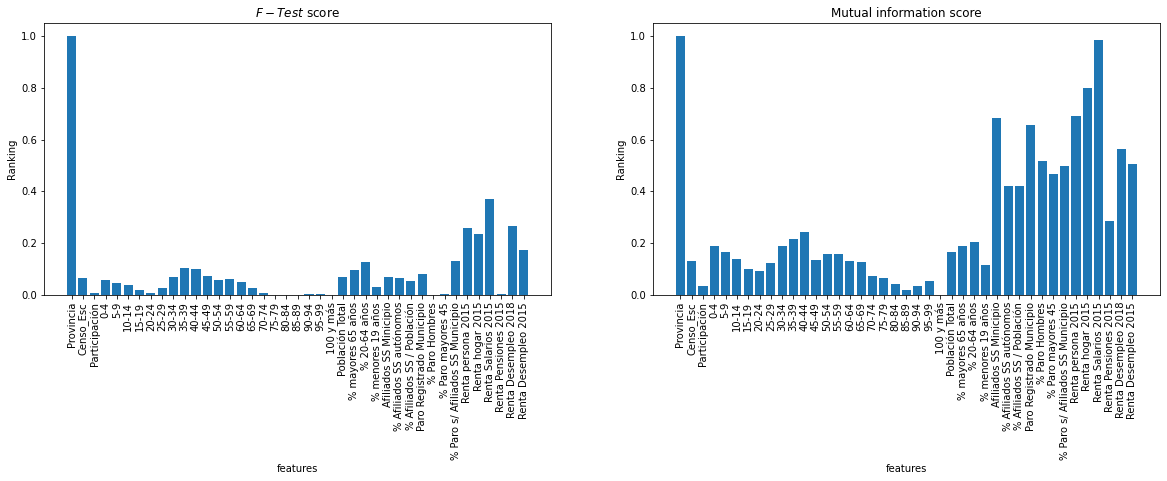

In [ ]:
y = y_train_v    # nos quedamos con la 1ª columna, price
X = X_train_v      # nos quedamos con el resto

feature_names = columnas


# do calculations
f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

# do some plotting
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.bar(range(X.shape[1]),f_test,  align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F-Test$ score')

plt.subplot(1,2,2)
plt.bar(range(X.shape[1]),mi, align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

Vemos que, además de la provincia, los datos económicos tienen más importancia que las edades. Almecenamos en una lista las columnas más importantes, concretamente 13, que utilizaremos más adelante.

In [ ]:
columnas_MI = columnas[mi > 0.35]

In [ ]:
columnas_MI

Index(['Provincia', 'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta persona 2015',
       'Renta hogar 2015', 'Renta Salarios 2015', 'Renta Desempleo 2018',
       'Renta Desempleo 2015'],
      dtype='object')

In [ ]:
len(columnas_MI)

13

## Modelización mediante redes neuronales

Ahora ya podemos modelizar, para lo cual cargamos las librerías necesarias para operar con redes neuronales.

In [ ]:
from tensorflow import keras

from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPool2D, Activation, Dropout, Dense, Flatten, Input, concatenate

from sklearn.preprocessing import MinMaxScaler

Es necesario siempre normalizar, y es lo que hacemos a continuación.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
cs = MinMaxScaler()

In [ ]:
X_train_norm = cs.fit_transform(X_train)
X_test_norm = cs.transform(X_test)

In [ ]:
max_Dif = y_train.abs().max()

In [ ]:
max_Dif

0.8653846153846153

Intentamos evitar datos negativos simplemente sumando 1 a los datos ya normalizados. Puede no ser riguroso del todo, pero los resultados veremos que son buenos.

In [ ]:
y_train_norm = y_train / max_Dif +1

y_test_norm = y_test / max_Dif +1

Y preparamos nuestra primera red neuronal, bastante simple, con dos capas, aparte de la final que nos da la estimación con la activación linear.

In [ ]:
def model_RN(dim, regress = True):
  model = Sequential()
  model.add(Dense(60, input_dim = dim, activation='relu'))
  model.add(Dropout(0.2))
  #model.add(Dense(24, activation = 'relu'))
  #model.add(Dropout(0.15))
  model.add(Dense(8, activation = 'relu'))


  if regress:
    model.add(Dense(1, activation = 'linear'))
  else:
    model.add(Dense(5, activation = 'softmax'))

  return model

In [ ]:
dim = X_train_norm.shape[1]

In [ ]:
dim

41

Instanciamos la red neuronal

In [ ]:
model_RN = model_RN(dim, regress = True)

Definimos el optimizador

In [ ]:
opt = keras.optimizers.Adam(lr = 0.001, decay = 0.001/50)

In [ ]:
opt

Definimos el modelo, bastante simple, con apenas 3.000 parámetros, y tomando comométrica el valor medio absoluto en porcentaje.

In [ ]:
model_RN.compile(optimizer=opt, loss = 'mean_absolute_percentage_error')

In [ ]:
model_RN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 60)                2520      
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 488       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 3,017
Trainable params: 3,017
Non-trainable params: 0
_________________________________________________________________


Y hacemos el fit. Vemos que

In [ ]:
model_RN.fit(x = X_train_norm,
              y= y_train_norm,
              validation_data = (X_test_norm, y_test_norm),
              verbose = 1,
              epochs = 50,
              batch_size = 40)

Epoch 1/50
725/725 [==============================] - 2s 2ms/step - loss: 19.3100 - val_loss: 8.8366
Epoch 2/50
725/725 [==============================] - 1s 2ms/step - loss: 10.5664 - val_loss: 8.2404
Epoch 3/50
725/725 [==============================] - 1s 2ms/step - loss: 9.7778 - val_loss: 8.1206
Epoch 4/50
725/725 [==============================] - 1s 2ms/step - loss: 9.1989 - val_loss: 7.9188
Epoch 5/50
725/725 [==============================] - 1s 2ms/step - loss: 8.8312 - val_loss: 7.8576
Epoch 6/50
725/725 [==============================] - 1s 2ms/step - loss: 8.5387 - val_loss: 7.9077
Epoch 7/50
725/725 [==============================] - 1s 2ms/step - loss: 8.3507 - val_loss: 7.8009
Epoch 8/50
725/725 [==============================] - 1s 2ms/step - loss: 8.2392 - val_loss: 7.7387
Epoch 9/50
725/725 [==============================] - 1s 2ms/step - loss: 8.1546 - val_loss: 7.8015
Epoch 10/50
725/725 [==============================] - 1s 2ms/step - loss: 8.0563 - val_loss: 7.69

Los resultados parecen ser relativamente satisfactorios, pues el error medio es del 7%, bastante bajo a nuestro juicio.

Ahora lo que hacemos es tomar únicamente las columnas con un alto MI, que vimos que eran 13.

In [ ]:
columnas_MI

Index(['Provincia', 'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta persona 2015',
       'Renta hogar 2015', 'Renta Salarios 2015', 'Renta Desempleo 2018',
       'Renta Desempleo 2015'],
      dtype='object')

In [ ]:
X_train_simp = X_train[columnas_MI]

In [ ]:
X_train_simp.shape

(28971, 13)

In [ ]:
X_test_simp = X_test[columnas_MI]

In [ ]:
X_test_simp.shape

(7244, 13)

Ahora normalizamos 

In [ ]:
X_train_simp_norm = cs.fit_transform(X_train_simp)
X_test_simp_norm = cs.transform(X_test_simp)

Definimos una red neuronal algo más compleja, pero tampoco demasiado, básicamente añadimos una capa más.

In [ ]:
def model_RN_simp(dim, regress = True):
  model = Sequential()
  model.add(Dense(120, input_dim = dim, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(24, activation = 'relu'))
  model.add(Dropout(0.15))
  model.add(Dense(8, activation = 'relu'))


  if regress:
    model.add(Dense(1, activation = 'linear'))
  else:
    model.add(Dense(5, activation = 'softmax'))

  return model

In [ ]:
dim = X_train_simp_norm.shape[1]

In [ ]:
dim

13

Instanciamos la red neuronal

In [ ]:
model_RN_simp = model_RN_simp(dim, regress = True)

Definimos el optimizador

In [ ]:
opt = keras.optimizers.Adam(lr = 0.001, decay = 0.001/50)

In [ ]:
model_RN_simp.compile(optimizer=opt, loss = 'mean_absolute_percentage_error')

Hemos incrementado el número de parámetros hasta cerca de 5.000

In [ ]:
model_RN_simp.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 120)               1680      
_________________________________________________________________
dropout_5 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 24)                2904      
_________________________________________________________________
dropout_6 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 200       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 9         
Total params: 4,793
Trainable params: 4,793
Non-trainable params: 0
____________________________________________________

Y hacemos el fit sin mayor novedad.

In [ ]:
model_RN_simp.fit(x = X_train_simp_norm,
              y= y_train_norm,
              validation_data = (X_test_simp_norm, y_test_norm),
              verbose = 1,
              epochs = 50,
              batch_size = 40)

Epoch 1/50
725/725 [==============================] - 2s 2ms/step - loss: 15.1989 - val_loss: 8.9006
Epoch 2/50
725/725 [==============================] - 2s 2ms/step - loss: 9.5365 - val_loss: 10.1359
Epoch 3/50
725/725 [==============================] - 2s 2ms/step - loss: 8.9035 - val_loss: 8.8722
Epoch 4/50
725/725 [==============================] - 1s 2ms/step - loss: 8.6933 - val_loss: 8.9072
Epoch 5/50
725/725 [==============================] - 1s 2ms/step - loss: 8.6472 - val_loss: 9.1152
Epoch 6/50
725/725 [==============================] - 1s 2ms/step - loss: 8.5561 - val_loss: 8.8115
Epoch 7/50
725/725 [==============================] - 2s 2ms/step - loss: 8.4710 - val_loss: 9.1070
Epoch 8/50
725/725 [==============================] - 1s 2ms/step - loss: 8.4269 - val_loss: 8.5291
Epoch 9/50
725/725 [==============================] - 2s 2ms/step - loss: 8.3652 - val_loss: 8.0958
Epoch 10/50
725/725 [==============================] - 2s 2ms/step - loss: 8.3251 - val_loss: 8.42

Lo cierto es que obtenemos un error algo mayor, posiblemente debido a la información de las más de 30 columnas que hemos descartado. Con todo, debido a que nos sería más fácil recolectar la información de apenas 13 columnas y no más de 40, si tuviésemos que elegir, nos quedaríamos con este último modelo.